# Learning and practicing ANOVA (ANalysis Of VAriance)

In the case of two samples, we use $Z$-test or $t$-test to test if the two groups have statistically different sample mean. When the number of groups is larger than 2, we use ANOVA. Say we have three groups, each with mean 3.5, 4.0, and 3.7. The question ANOVA is desgined to answer if the between group difference of the mean is statistically significant or due to the inherent variability.

### Law of total variance
ANOVA is a direct application of law of total variance, which decompose the total variance into expectation of conditional variance and the variance of conditional expectations, <br> 
$Var(X) = E[Var(X|Y)] + Var(E[X|Y])$, <br>
where the first term on the RHS is the expected within-group variance and the second term on the RHS is the between group variance of means of different groups. The proof is omitted here.

In the case of ANOVA, the null hypothesis is that $X|Y_1, X|Y_2, ..., X|Y_n$ follows a IID normal distribution. Under the assumption of null hypothesis, $Var(E[X|Y]) = Var(const) = 0$ and $E[Var(X|Y)] = E[Var(X)] = Var(X)$, which means the total variability only comes from the within group variability. 

However, after proper rescaling, the within-group sum of squares and the between-group sum of squares are should be comparable.

Let's say we have a simple case of three samples X, Y and Z, $X_1, X_2, ..., X_{n_X}; Y_1, Y_2, ..., Y_{n_Y}; Z_1, Z_2, ..., Z_{n_Z}$. Under the null hypothesis, X, Y, Z follows a normal distribution $N(\mu, \sigma^2)$ with unknown mean $\mu$ and variance $\sigma^2$. Define the sum of squares: <br>

$SS_X = \sum_i (X_i-\bar{X})^2/\sigma^2 \sim \chi_{n_X-1}^2$

$SS_Y = \sum_i (Y_i-\bar{Y})^2/\sigma^2 \sim \chi_{n_Y-1}^2$

$SS_Z = \sum_i (Z_i-\bar{Z})^2/\sigma^2 \sim \chi_{n_Z-1}^2$

Therefore, we have the within-group sum of squares follow:
$SS_{wg}$ =  $SS_X + SS_Y + SS_Z \sim \chi_{n_X + n_Y + n_Z - 3}^2$

It can also be shown that, $\bar{X}, \bar{Y}, \bar{Z}$ also follows $N(\mu, \sigma^2/n_X), N(\mu, \sigma^2/n_Y), N(\mu, \sigma^2/n_Z)$ independent of $SS_X, SS_Y, SS_Z$, thus also independent of $SS_{wg}$. The global mean $\bar{W} = (n_X\bar{X} + n_Y\bar{Y} + n_Z\bar{Z})/(n_X + n_Y + n_Z) \sim N(\mu, \sigma^2/(n_X+n_Y+n_Z))$. The between group sum of squares $SS_{bg}$ is defined as:

$SS_{bg} = n_X (\bar{X}-\bar{W})^2 + n_Y (\bar{Y}-\bar{W})^2 + n_Z (\bar{Z}-\bar{W})^2$

which follows another $\chi_{2}^2$.

F statistics is defined as: $F = \frac{SS_{bg}/df_{bg}}{SS_{wg}/df_{wg}}$, where $SS_{bg}$ and $SS_{wg}$ follows $\chi^2$ distribution with degree of freedom $df_{bg}$ and $df_{wg}$. Under null hypothesis, F should be less or comparable to 1.0. Extreme values much larger than 1 give evidence against the null hypothesis.

In [14]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

### Example: One-way F test
The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

#### Assumptions
The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

The samples are independent.<br>
Each sample is from a normally distributed population.<br>
The population standard deviations of the groups are all equal. This property is known as homoscedasticity.<br>

If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test (```scipy.stats.kruskal```) although with some loss of power.

In [41]:
def rANOVA(*args):
    """return the F statistics and p value after applying r-ANOVA
    args: array like, sample1, sample 2, ...
    ref: http://vassarstats.net/textbook/ch12a.html
    """
    # convert *args into dataframe.
    data = np.vstack(args).T
    df   = pd.DataFrame(data, dtype=float)
    n,   k  = df.shape
    n_T     = n*k
    M_k     = df.mean()
    M       = M_k.mean()
    SS_bg   = (df.sum()**2).sum()/n - (df.sum().sum())**2/n_T
    SS_wg   = ((df**2).sum() - df.sum()**2/n).sum()
    SS_subj = (df.sum(axis=1)**2).sum()/k - (df.sum().sum())**2/n_T
    SS_err  = SS_wg - SS_subj
    df_T    = n_T - 1
    df_bg   = k - 1
    df_wg   = n_T - k
    df_subj = n - 1
    df_err  = df_wg - df_subj
    MS_bg   = SS_bg/df_bg
    MS_err  = SS_err/df_err
    F       = MS_bg/MS_err
    pvalue  = 1 - scipy.stats.f.cdf(F, df_bg, df_err) 
    return F, pvalue

def plot_dignostics(samples, labels = None, test = 'f', bins=15):
    """
    make box plots for multiple samples and perform statistical tests.
    """
    n=len(samples)
    # box plots.
    if not labels:
        labels = ['X%d'%(i) for i in range(n)] 
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.boxplot(samples, positions=list(range(n)), labels=labels, widths=0.5)
    
    plt.subplot(1,2,2)
    for i in range(n):
        plt.hist(samples[i],alpha=0.8,bins=bins)
    plt.legend(labels)
    
    test = test.lower()
    implemented_tests = ['kruskal','f','friedman','ranova']
    
    if test=='f':
        T, pvalue = scipy.stats.f_oneway(*samples)
    elif test=='kruskal':
        T, pvalue = scipy.stats.kruskal(*samples)
    elif test=='friedman':
        T, pvalue = scipy.stats.friedmanchisquare(*samples)
    elif test=='ranova':
        T, pvalue = rANOVA(*samples)
    else:
        print('%s is not supported，please use: %s'%(test,','.join(implemented_tests)))
        return None
    
    if test in implemented_tests:
        print('%s test statistics T: %8.5f and P-vale %10.8f' % (test,T, pvalue))
        if pvalue<0.05:
            print('Reject null hypothesis at 95% confidence')
        else:
            print('Fail to reject null hypothesis at 95% confidence')
        return T, pvalue

f test statistics T:  1.29628 and P-vale 0.27486874
Fail to reject null hypothesis at 95% confidence


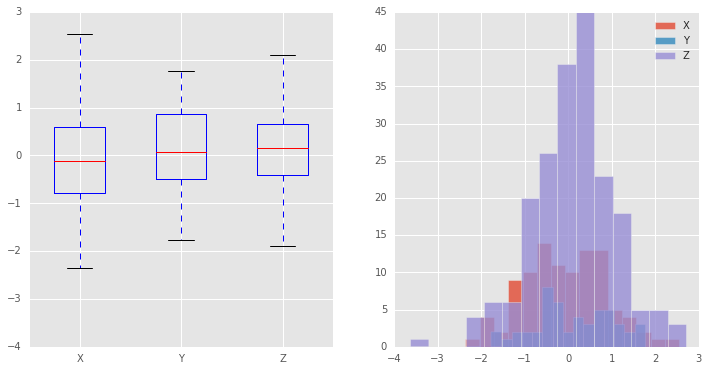

In [42]:
X = np.random.randn(100)
Y = np.random.randn(50) + 0.1
Z = np.random.randn(200) + 0.1
T, pvalue = plot_dignostics([X,Y,Z],labels=['X','Y','Z'], test='f')

### Visualize F distribution
This is how F-distribution look like. See also: https://en.wikipedia.org/wiki/F-distribution

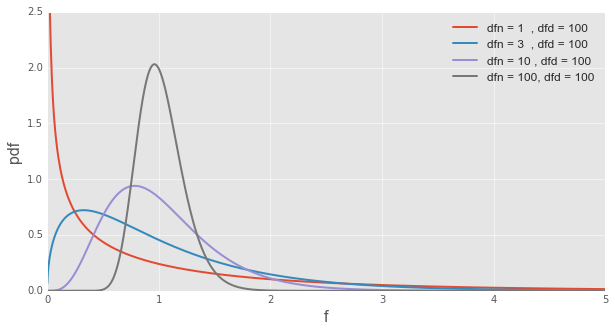

In [150]:
X   = np.linspace(0.001,5,1000)
dfn = 10
dfd = 100
def plotF(dfn=2, dfd=5, X = np.linspace(0.001,5,1000),ax = None):
    y   = scipy.stats.f.pdf(X, dfn, dfd)
    if ax:
        plt.plot(X, y, linewidth=2, ax=ax)
    else:
        plt.plot(X, y, linewidth=2)
    plt.ylim([0,2.5])

fig=plt.figure(figsize=(10, 5))
plotF(1,100)
plotF(3,100)
plotF(10,100)
plotF(100,100)
legends = ['1','3','10','100']
plt.legend(['dfn = %-3s, dfd = 100'%(l) for l in legends])
plt.ylabel('pdf',fontsize=16)
plt.xlabel('f',fontsize=16)

### Another example of one way F test

The analysis of variance is a very __robust__ test, in the sense that it is relatively unperturbed when the equal-variance assumption is not met. This is especially so when the k samples are all of the same size, as in the present example. Hence, for this or any other version of ANOVA, it is always a good idea to ensure that all samples are of the same size.

When the several samples are of different sizes, the rule of thumb mentioned above remains in force: the ratio of the largest sample variance to the smallest should not exceed 1.5.

### Another example with unequal variance but with equal sample size

Test statistics T:  3.16660 and P-vale 0.04333304
Reject null hypothesis at 95% confidence


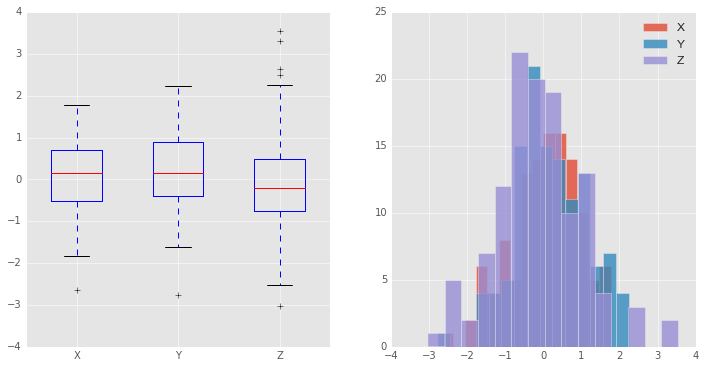

In [174]:
sigma_x = 1.0
sigma_y = 0.75
sigma_z = 1.5

X = np.random.normal(loc=0.0,  scale= 1.0, size=120)
Y = np.random.normal(loc=0.15,  scale= np.sqrt(0.75), size=120)
Z = np.random.normal(loc=-0.1, scale= np.sqrt(1.25), size=120)

T, pvalue = plot_dignostics([X,Y,Z],labels=['X','Y','Z'],Ftest=True)
print('Test statistics T: %8.5f and P-vale %10.8f' % (T, pvalue))
if pvalue<0.05:
    print('Reject null hypothesis at 95% confidence')
else:
    print('Fail to reject null hypothesis at 95% confidence')

### Krustal-Wallis test
When neither sample sizes nor the sample variance are the same, we cannot apply ANOVA. In this case, the non-parametric test Kruskal–Wallis test becomes handy.

Procedure:
1. Rank all data from all groups together; i.e., rank the data from $1$ to $N$ ignoring group membership. Assign any tied values the average of the ranks they would have received had they not been tied.
2. Calculate the following statistics:

$H=(N-1)\frac{\sum_{i=1}^g n_{i}(\bar{r}_i-\bar{r})^2}{\sum_{i=1}^g \sum_{j=1}^{n_i}(r_{ij}-\bar{r})^2}$

where $N$ is total number of samples, $n_{i}$ is the number of samples in group $i$, $g$ is number of groups, $r_{ij}$ is the rank (among) all the observations of observation $j$ from group $i$. $\bar{r}_{i} = \frac{\sum_{j=1}^{n_{i}}r_{ij}}{n_i}$ is the average rank of all observations in the group $i$. $\bar{r}=(N+1)/2$ is the average of all the $r_{ij}$.

This statistics should be close to zero and follows $\chi_{g-1}^2$ distribution under the null hypothesis: all the groups follow have equal medians. Significant Krustal-Wallis test gives evidence against equal medians, thus also evidence against same distributions. Due to the assumption that H has a $\chi^2$ distribution, the number of samples in each group must not be too small. A typical rule is that each sample must have at least 5 measurements.

Detailed procedure of Krustal-Wallist test is discussed here:https://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance. 

Assumptions:
1. random samples from populations
2. independence within each sample
3. mutual independence among samples
4. measurement scale is at least ordinal
5. either $g$ population distribution functions are identical, or else some of the populations tend to yield larger values than other populations

This test can be regarded as an extension to the two sample rank sum test (or the Mann-Whitney U test) when there are more than two groups. A significant Kruskal–Wallis test indicates that at least one sample stochastically dominates one other sample. __The test does not identify where this _stochastic dominance_ occurs or for how many pairs of groups stochastic dominance obtains.__ For analyzing the specific sample pairs for stochastic dominance in post hoc testing, Dunn's test, pairwise Mann-Whitney tests without Bonferroni correction, or the more powerful but less well known Conover–Iman test are appropriate.

When the sample size is small, we can either enumerate all possible permuation of data and its associated ranks and calculate the distribution of statistics, or we can use perform a simulation.

F Test statistics T:  2.60109 and P-vale 0.07814157
Fail to reject null hypothesis at 95% confidence
Kruskal Test statistics T:  8.29275 and P-vale 0.01582163
Reject null hypothesis at 95% confidence


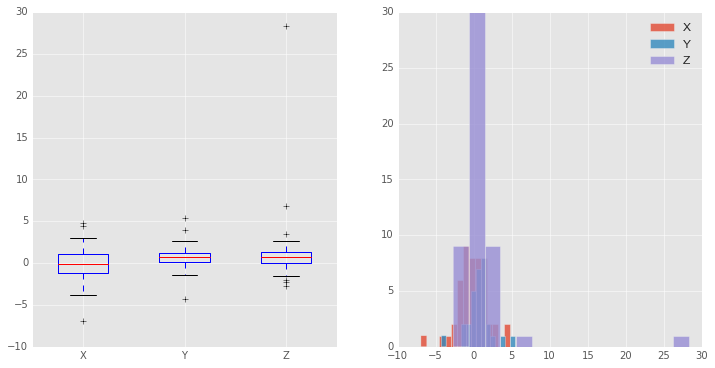

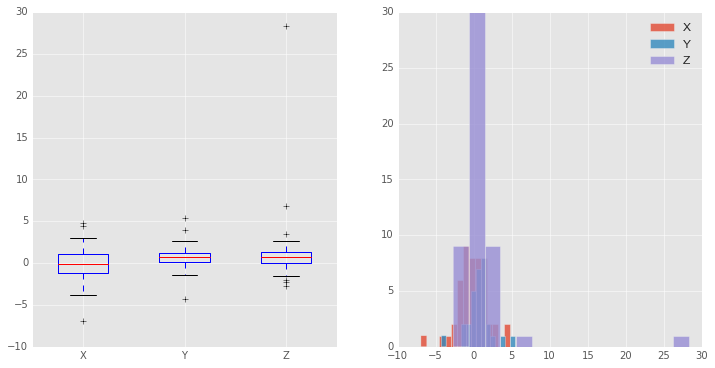

In [211]:
X = scipy.stats.t.rvs(df=2, loc=0,   scale=1, size=50)
Y = scipy.stats.t.rvs(df=2, loc=0.5, scale=1, size=30)
Z = scipy.stats.t.rvs(df=2, loc=0.35, scale=1, size=50)

T, pvalue = plot_dignostics([X,Y,Z],labels=['X','Y','Z'], test='f')
print('F Test statistics T: %8.5f and P-vale %10.8f' % (T, pvalue))
if pvalue<0.05:
    print('Reject null hypothesis at 95% confidence')
else:
    print('Fail to reject null hypothesis at 95% confidence')

T, pvalue = plot_dignostics([X,Y,Z],labels=['X','Y','Z'], test='kruskal')
print('Kruskal Test statistics T: %8.5f and P-vale %10.8f' % (T, pvalue))
if pvalue<0.05:
    print('Reject null hypothesis at 95% confidence')
else:
    print('Fail to reject null hypothesis at 95% confidence')

We can see that Krustal-Wallist is less sensitive to outliers and to normal assumptions.

### One-Way Analysis of Variance for Correlated Samples-rANOVA

This test corresponds to the repeated design where the same subject to exposed to multiple treatments. Therefore, the outcome of each treatment can be highly correlated. In this case, it's highly possible that there's dramatic pre-existing individual differences among different subjects. This extraneous varibility is totally unrelevant to the experiment itself. In correlated-samples ANOVA, this individual subject variability is identified and removed. In addition to the assumption of simple one-way ANOVA, one more assumption is that samples from each treatment group is positively correlated with same covariance ('sphericity').

The detailed procedure is discussed here:http://vassarstats.net/textbook/ch12a.html and https://en.wikipedia.org/wiki/Repeated_measures_design#Repeated_measures_ANOVA.

Here I give an example. Say, we have an repeated experiment on 50 subjects, with each subjects exposed to 3 treatements (A, B and C). These treatments are expected to make a difference in improving each subject's performance during a particular exam, measured by the exam scores.

To articulate the point, we create the sample by adding 3 treatment effects on a base.

In [47]:
import pandas as pd
import seaborn as sns
k = 3
n = 50
N = k*n
base    = np.random.choice(list(range(50,100)), n)
effectA = np.random.normal(loc=0,scale=5, size=n)
effectB = np.random.normal(loc=2,scale=5, size=n)
effectC = np.random.normal(loc=3,scale=5, size=n)
A =  base + effectA
B =  base + effectB
C =  base + effectC
labels = ['A','B','C']

Visualize the data A, B, C

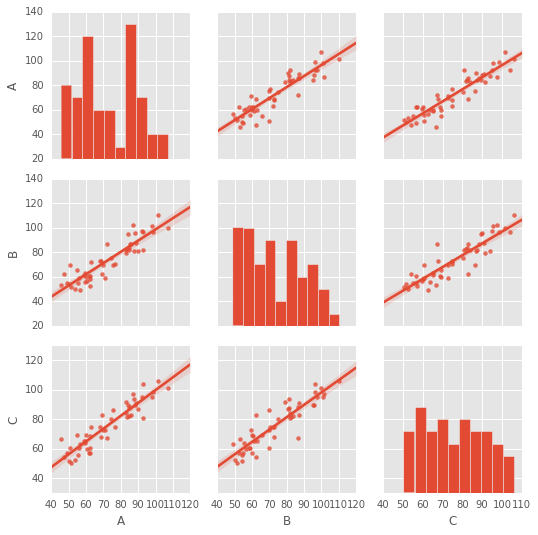

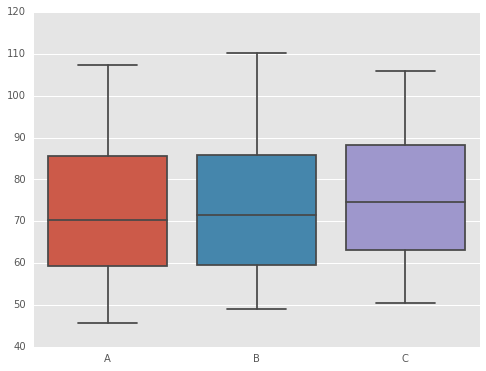

In [48]:
X = pd.DataFrame([A,B,C]).T
X.columns = labels
plt.figure(figsize=(16,16))
sns.pairplot(X, kind="reg")
plt.figure(figsize=(8,6))
sns.boxplot(data=X)

Clearly, A, B, C are positively correlated. Now, let's ignore the subject differences and apply one-way ANOVA.

f test statistics T:  0.55010 and P-vale 0.57807504
Fail to reject null hypothesis at 95% confidence


(0.5500999539989142, 0.57807503701191099)

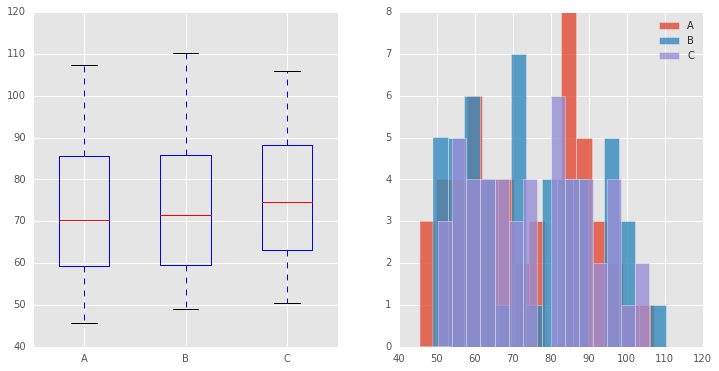

In [49]:
plot_dignostics([A, B, C], labels = labels, test = 'f', bins=15)

The subject variability prevents the one-way ANOVA to reject the null hypothesis. __Now, let's apply r-ANOVA__

Before r-ANOVA tests, it's good practice to check the sphericity assumption is valid and correlation in subjects in different group does exist like we did!

In [259]:
X.head(10)

,A,B,C
0,46.890495,48.234068,56.763277
1,50.602953,58.716826,60.604588
2,65.505064,60.382932,61.994973
3,55.586644,65.026348,71.083102
4,46.504314,53.193313,52.519970
5,69.630953,76.172315,70.364840
6,70.056838,78.717520,78.423933
7,69.910409,75.275629,73.266201
8,70.783477,75.521076,80.670797
9,81.388293,81.333113,85.139839


ranova test statistics T:  6.13275 and P-vale 0.00309409
Reject null hypothesis at 95% confidence


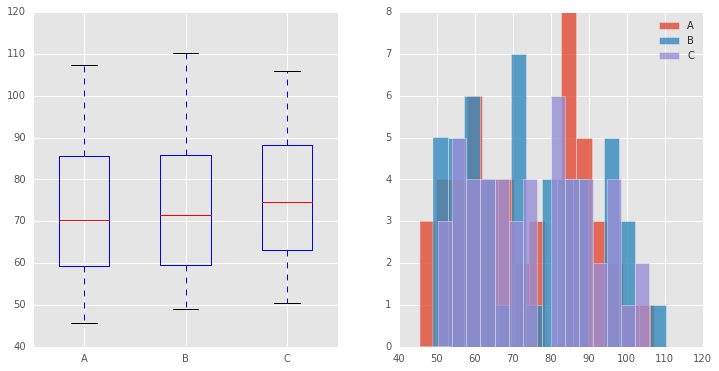

In [50]:
T, pvalue = plot_dignostics([A,B,C],labels=labels, test='ranova')

### Post-ANOVA Comparisons: the Tukey HSD (honest significant difference) Test 

A significant F-ratio tells you only that the aggregate difference among the means of the several samples is significantly greater than zero. It does not tell you whether any particular sample mean significantly differs from any particular other. Tukey HSD test compares all possible pairs of means, and is based on a studentized range distribution (q) (this distribution is similar to the distribution of t from the t-test). It is one of the post-hoc analysis methods.

Reference can be found:
https://en.wikipedia.org/wiki/Tukey%27s_range_test
http://vassarstats.net/textbook/ch12a.html

In [365]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import numpy as np
from scipy import stats
n = 50
X = scipy.stats.norm.rvs(loc=0,    scale=1, size=n)
Y = scipy.stats.norm.rvs(loc=0.5,  scale=1, size=n)
Z = scipy.stats.norm.rvs(loc=0.5,  scale=1, size=n)

f, p = stats.f_oneway(X,Y,Z)

print ('One-way ANOVA')
print ('=============')
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 4.3357728997
P value: 0.0148062513052 



In [367]:
data  = np.concatenate([X , Y , Z])
group =['X']*n+['Y']*n+['Z']*n

In [368]:
mc = MultiComparison(data, group)
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  X      Y     0.571    0.084  1.058   True 
  X      Z     0.4604  -0.0266 0.9475 False 
  Y      Z    -0.1105  -0.5975 0.3765 False 
--------------------------------------------


Tukey HSD test gives confidence interval of the difference in mean for each pairs after correcting for the family wise error rate (FWER).

## Friedman Test
#### A non-parametric alternative to r-ANOVA
Reference:<br> 
http://vassarstats.net/textbook/ch12a.html.<br>
https://en.wikipedia.org/wiki/Friedman_test<br>
When the one or more assumptions of r-ANOVA are violated, a non-parametric rank-based procedure Friedman test becomes handy. These situations can be that the measurments are equal interval based, such as ranking, ratings.  There's also good chance that the assumption of normal distribution of source populations would not be met.

Classic examples of use are:
* n wine judges each rate k different wines. Are any of the k wines ranked consistently higher or lower than the others?
* n welders each use k welding torches, and the ensuing welds were rated on quality. Do any of the k torches produce consistently better or worse welds?

The procedure involves ranking each row (or block) together, then considering the values of ranks by columns. Say we have n blocks with k different treatments. Under the assumption of null hypothesis (no significant difference between k treatments), then k treatment is equally likely to have rank from 1 to k (if no ties). Because the ranks are only related to values within each row (or block), the between subject or block variability is automatically removed!

1. Given data $\{x_{ij}\}_{n\times k}$, that is, a matrix with $n$ rows (the blocks), $k$ columns (the treatments) and a single observation at the intersection of each block and treatment, calculate the ranks within each block. If there are tied values, assign to each tied value the average of the ranks that would have been assigned without ties. Replace the data with a new matrix $\{r_{ij}\}_{n\times k}$ where the entry $r_{ij}$ is the rank of $x_{ij}$ within block $i$.

2. Find values:
    * $\bar{r}_{j}= \frac{1}{n} \sum_{i=1}^{n}r_{ij}$
    * $\bar{r} = \frac{1}{nk} \sum_{i=1}^{n}\sum_{j=1}^{k} r_{ij}$
    * $SS_{t} = n\sum_{j=1}^{k}(\bar{r}_{j}-\bar{r})^2$
    * $SS_{e} = \frac{1}{n(k-1)}\sum_{i=1}^{n}\sum_{j=1}^{k}(r_{ij}-\bar{r})^2$

3. The test statistics is given by $Q = \frac{SS_t}{SS_e}$. 
4. When $n$ or $k$ is large (i.e. $n>15$ or $k>4$), the probability distribution of $Q$ can be approximated by that of a chi-square distribution $\chi_{k-1}^2$.

The logics behind these formula are as follow:
1. $\sqrt{SS_{e}}$ is sample standard error which is an estimate of the sample standard deviation.
2. From central limit theorem (CLT), $\sqrt{n} (\bar{r}_{j}-\bar{r})/\sqrt{SS_{e}}$ is approximately normal distribution as $n$ is large. 
3. $Q$ can be rewritten in the following form: $Q = \sum_{j=1}^{k} \left(\sqrt{n}( \bar{r}_{j}-\bar{r})/\sqrt{SS_{e}} \right )^2$, which is approximately a sum of iid normal distribution. However, since mean is replaced by sample mean, the degree of freedom is $k-1$.

Friedman test is one type of permutation test, which explore the symmetry of ranks of different treatments under null hypothesis. Therefore, we can also use simulation or enumerate all the possible permutation of the data to calculate the distribution of statistics empirically.

### Friedman test example

Let's compare if customers ratings (from 1 *very bad* to 10 *excellent*) for 4 different services. The null hypothesis is that the services are not significantly different. Since the rating is not a equal interval based measure, we cannot use r-anova and here we use friedman test.

In [31]:
n = 20
base = np.random.choice(list(range(4,8)), n)
a    = base + np.random.choice(range(-2, 4), n)
b    = base + np.random.choice(range(-3, 3), n)
c    = base + np.random.choice(range(-3, 2), n)

Visualize the data to check correlations and assumption of sphericity

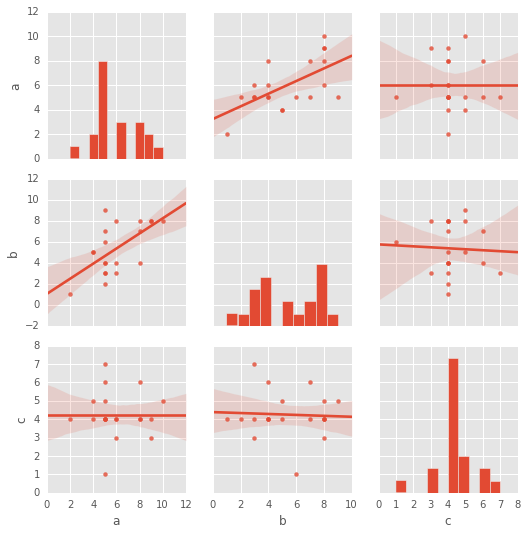

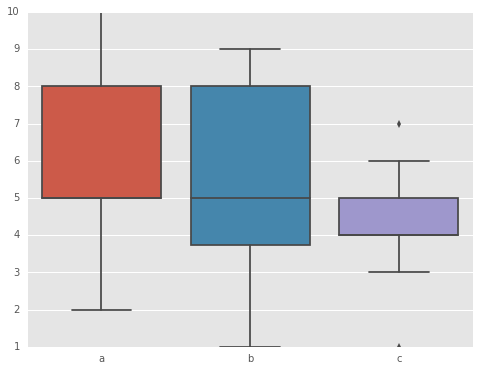

In [32]:
X = pd.DataFrame([a,b,c]).T
labels = ['a','b','c']
X.columns = labels
plt.figure(figsize=(16,16))
sns.pairplot(X, kind="reg")
plt.figure(figsize=(8,6))
sns.boxplot(data=X)

Apply Friedman test

friedman test statistics T:  7.19444 and P-vale 0.02739973
Reject null hypothesis at 95% confidence


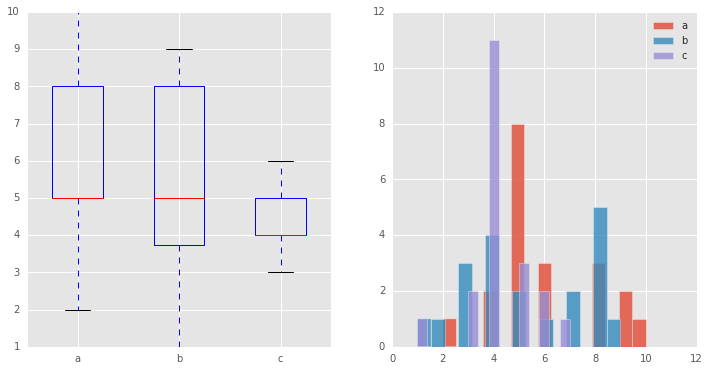

In [33]:
T, pvalue = plot_dignostics([a,b,c],labels=labels, test='Friedman')